In [1]:
import skimage
import matplotlib.pyplot as plt
import jseg
from jseg.data import overlapping_circles
from jseg.evaluation import segmentation_type
from skimage.metrics import variation_of_information, adapted_rand_error, contingency_table
import numpy as np
import jseg.evaluation as jeval
from collections import defaultdict

## Overlapping Circles

In [2]:
jeval.SEGMENTATION_TYPES

['extra-segmentation',
 'missed-segmentation',
 'correct-segmentation',
 'over-segmentation',
 'under-segmentation',
 'divergent-segmentation']

RATES: correct 1.0 over 0.0 under 0.0 miss 0.0 divergent 0.0
Over segmentation:  0.0  Under segmentation:  0.0  Adapted random Error:  0.0  ar-prec:  1.0  ar rec:  1.0
  (1, 5)	650909.0
  (2, 5)	152798.0
  (3, 3)	196293.0


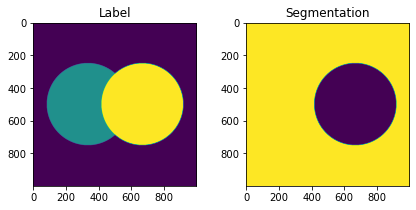

In [3]:
# Print all the different overlapping situation 
shape = (1000, 1000)
fig,axs = plt.subplots(1,2)
fig.set_size_inches(7,3)
label, segmentation = overlapping_circles(segmentation_type= 'missed-segmentation',
                                            background_label = 1,
                                            shape = shape,
                                            label_shift = False)
segmentation[segmentation == 1] = 5
axs[0].imshow(label)
axs[0].set_title("Label")
axs[1].imshow(segmentation)
axs[1].set_title("Segmentation")

num_gt = len(np.unique(label))-1
ct = contingency_table(label, segmentation, ignore_labels=(0,), normalize=False)
ct1 = contingency_table(label, segmentation, ignore_labels=(1,), normalize=False)
ov, un = variation_of_information(label, segmentation, table = ct1)
are, prec, rec = adapted_rand_error(label, segmentation,table = ct1)
cor ,ovr, unr, mir, dir =  segmentation_type(ct,num_gt, background_label=1)
print(f"RATES: correct {cor} over {ovr} under {unr} miss {mir} divergent {dir}")
print("Over segmentation: ", ov, " Under segmentation: ", un, " Adapted random Error: ", are, " ar-prec: ", prec, " ar rec: ", rec)
print(ct)


In [39]:
vij = get_vji(label, segmentation, 1)
vij

0.7784179772075418

In [28]:
def create_connections(cont_table):
    ct = cont_table
    g2p = dict()
    g2max = defaultdict(int)
    p2g = dict()
    p2max = defaultdict(int)
    for g, p, val in zip(ct.tocoo().row ,ct.tocoo().col,ct.tocoo().data):
        if val >= g2max[g]:
            g2max[g] = val
            g2p[g] = p
        if val >= p2max[p]:
            p2max[p] = val
            p2g[p] = g    

    # create connections
    connections = set()
    temp_con = []
    for g,p in g2p.items():
        temp_con.append([(g,p))

    for p,g in p2g.items():
        temp_con.append((g,p))
    connections.update(temp_con)
    return connections

[{'gs': {1}, 'ps': {3}, 'segmentation-type': 'extra-background-segmentation'},
 {'gs': {2}, 'ps': {2}, 'segmentation-type': 'correct-segmentation'}]

In [30]:

connections = create_connections(ct)
background_label = bg
connections.remove((background_label, background_label))

# calculate clusters
clusters = []
for g,p in connections:
    g_match = False
    p_match = False
    if g != background_label:
        for ci_g,cluster in enumerate(clusters):
            if not cluster['gs'].isdisjoint([g]):
                g_match = True
                break
        
    if p != background_label:
        for ci_p, cluster in enumerate(clusters):
            if not cluster['ps'].isdisjoint([p]):
                p_match = True
                break
    if not g_match and not p_match:
        clusters.append({'gs':{g},'ps': {p}})
    elif g_match and not p_match:
        clusters[ci_g]['gs'].update([g])
        clusters[ci_g]['ps'].update([p])
    elif not g_match and p_match:
        clusters[ci_p]['gs'].update([g])
        clusters[ci_p]['ps'].update([p])
    elif ci_g == ci_p:
        # They are the same
        clusters[ci_g]['gs'].update([g])
        clusters[ci_g]['ps'].update([p])
    elif ci_g != ci_p:
        base_index = max(ci_g, ci_p)
        append_index = min(ci_g, ci_p)
        append_cluster = clusters.pop(append_index)
        clusters[base_index]['gs'].update(append_cluster['gs'])
        clusters[base_index]['ps'].update(append_cluster['ps'])
# Take away the 

for cluster in clusters:
    num_gs = len(cluster['gs'])
    num_ps = len(cluster['ps'])
    bg_in_gs = background_label in cluster['gs']
    bg_in_ps = background_label in cluster['ps']
    assert num_gs > 0, "Most be atleast one ground node in cluster"
    assert num_ps > 0, "Most be atleast one prediction node in cluster"
    assert not (bg_in_gs and bg_in_ps), "Background can't be in both"
    if bg_in_gs or bg_in_ps:
        if num_gs == 1 and num_ps == 1:
            if bg_in_gs:
                cluster['segmentation-type'] = "extra-background-segmentation"
            elif bg_in_ps:
                cluster['segmentation-type'] = "missed-background-segmentation"
            else: 
                assert False, "Should never get here"
        elif num_gs == 1 and num_ps > 1:
            cluster['segmentation-type'] = "over-background-segmentation"
        elif num_gs > 1 and num_ps == 1:
            cluster['segmentation-type'] = "under-background-segmentation"
        else:
            cluster['segmentation-type'] = "divergent-background-segmentation"
    else: 
        if num_gs == 1 and num_ps == 1: 
            if bg_in_gs:
                cluster['segmentation-type'] = "background-segmentation"
            elif bg_in_ps:
                cluster['segmentation-type'] = "missed-segmentation"
            else:
                cluster['segmentation-type'] = "correct-segmentation"
        elif num_gs == 1 and num_ps > 1:
            cluster['segmentation-type'] = "over-segmentation"
        elif num_gs > 1 and num_ps == 1:
            cluster['segmentation-type'] = "under-segmentation"
        else:
            cluster['segmentation-type'] = "divergent-segmentation"
# merge background and cell clusters
clusters

[{'gs': {2}, 'ps': {2, 3}, 'segmentation-type': 'over-segmentation'}]

# Finding

## Adaptive random error
Goes between 0 - 1 where 0 is the best. It is not sensitive to that label and segmentation might be labeled differently.

## Contingency table
Get all pairs that overlap and calculates how much they overlapp. This is sparse matrix of shape (max_true+1, max_pred+1)

## Test evaluation method

In [4]:
gt_dir = "/scratch/ottosson/datasets/FM/data/label"
pr_dir = "/scratch/ottosson/datasets/FM/data/plantseg_0/segmentation"
data_df = jeval.evaluate_plantseg(gt_dir, pr_dir)

In [27]:
def get_vji(ground_truth, prediction, background_label):
    gt_unique = np.unique(ground_truth)
    pr_unique = np.unique(prediction)
    total_g = 0
    total_val = 0
    for g in gt_unique:
        if g == background_label: continue
        g_coords = np.where(ground_truth == g)
        g_set = set((coord) for coord in zip(*g_coords))
        total_g += len(g_set)
        best_p = -1
        best_val = -1
        for p in pr_unique:
            if p == background_label: continue
            p_coords = np.where(prediction == p)
            p_set = set((coord) for coord in zip(*p_coords))
            val = len(g_set)*len(g_set.intersection(p_set))/len(g_set.union(p_set))
            if val >= best_val:
                best_val = val
                best_p = p
        total_val += best_val
    return total_val / total_g



In [13]:
a = set((4,5,5))
b = set((6,7,1,2,3,4))

In [16]:
a.union(b)

{1, 2, 3, 4, 5, 6, 7}

In [10]:
set((r,c) for r,c, in zip(rows, cols))


{(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (2, 3)}

In [11]:
    with open(config_file, 'w') as outfile:
        yaml.dump(con, outfile, default_flow_style=False)